In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import os
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#导入数据
# housedata=fetch_california_housing()
#划分测试集和训练集
# df_train= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/all.csv')
# x = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1).values
# y = df_train['logerror'].values
# train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.1,random_state=42)
#划分测试集和训练集
process_dataset_x= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/process_dataset_x.csv',index_col=0)
process_dataset_y= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/process_dataset_y.csv',index_col=0)
x = process_dataset_x
y = process_dataset_y['logerror']
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.1,random_state=42)
# from sklearn.preprocessing import StandardScaler
# #标准化处理
scale=StandardScaler()
train_x=scale.fit_transform(train_x)
test_x=scale.fit_transform(test_x)


del x,y
train_x.shape,train_y.shape,test_x.shape,test_y.shape,max(train_y),min(train_y),max(test_y),min(test_y)

((148084, 81),
 (148084,),
 (16454, 81),
 (16454,),
 0.428162348933,
 -0.400350158603,
 0.425186135849,
 -0.399102826816)

In [3]:
train_x=np.array(train_x)
train_y=np.array(train_y)
test_x=np.array(test_x)
test_y=np.array(test_y)


In [4]:
count=1
count1=1
for i in range(len(test_y)):
    if -1<test_y[i]<1:
        count+=1
for i in range(len(test_y)):
    if -0.5<test_y[i]<0.6:
        count1+=1
print(len(test_y),count,count1)

16454 16455 16455


In [5]:
# Split dataset
def split_list_n_list(origin_list, n):
    if len(origin_list) % n == 0:
        cnt = len(origin_list) // n
    else:
        cnt = len(origin_list) // n + 1
 
    for i in range(0, n):
        yield origin_list[i*cnt:(i+1)*cnt]

In [6]:
#preparing teacher's datasets
n_teachers=30

teacher_x,teacher_y = [],[]
teacher_datasets = []
teacher_data_loader = []



teacher_x_loder = split_list_n_list(train_x,n_teachers)
teacher_y_loder = split_list_n_list(train_y,n_teachers)

teacher_x.extend(iter(teacher_x_loder))
teacher_y.extend(iter(teacher_y_loder))

for i in range(n_teachers):
    print(i,teacher_x[i].shape,teacher_y[i].shape)


from torch.utils.data import TensorDataset, DataLoader
teacher_datasets.extend(TensorDataset(torch.tensor(teacher_x[u],device=device,dtype=torch.float),
                                       torch.tensor(teacher_y[u],device=device,dtype=torch.float))
                        for u in  range(n_teachers))

teacher_data_loader.extend(DataLoader(teacher_datasets[i],batch_size=128,shuffle=True)
                           for i in range(n_teachers))


    

0 (4937, 81) (4937,)
1 (4937, 81) (4937,)
2 (4937, 81) (4937,)
3 (4937, 81) (4937,)
4 (4937, 81) (4937,)
5 (4937, 81) (4937,)
6 (4937, 81) (4937,)
7 (4937, 81) (4937,)
8 (4937, 81) (4937,)
9 (4937, 81) (4937,)
10 (4937, 81) (4937,)
11 (4937, 81) (4937,)
12 (4937, 81) (4937,)
13 (4937, 81) (4937,)
14 (4937, 81) (4937,)
15 (4937, 81) (4937,)
16 (4937, 81) (4937,)
17 (4937, 81) (4937,)
18 (4937, 81) (4937,)
19 (4937, 81) (4937,)
20 (4937, 81) (4937,)
21 (4937, 81) (4937,)
22 (4937, 81) (4937,)
23 (4937, 81) (4937,)
24 (4937, 81) (4937,)
25 (4937, 81) (4937,)
26 (4937, 81) (4937,)
27 (4937, 81) (4937,)
28 (4937, 81) (4937,)
29 (4911, 81) (4911,)


In [6]:
#preparing student's dataset
from pickle import TRUE


student_x,student_y = [] ,[]
student_datasets= []
 

student_x_loder =  split_list_n_list(test_x,2)
student_y_loder =  split_list_n_list(test_y,2)
student_x.extend(iter(student_x_loder))
student_y.extend(iter(student_y_loder))

for i in range(2):
    print(i,student_x[i].shape,student_y[i].shape)

student_datasets.extend(
                        TensorDataset(torch.tensor(student_x[u],device=device,dtype=torch.float),
                                      torch.tensor(student_y[u],device=device,dtype=torch.float))
                        for u in range(2)
)

student_train_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]),shuffle=True)
student_test_loader = DataLoader(student_datasets[1], batch_size=len(student_datasets[1]),shuffle=True)
samples= student_x[i].shape[0]
print(samples)


0 (8227, 81) (8227,)
1 (8227, 81) (8227,)
8227


In [7]:
#define metrics


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import pyro
from pyro.distributions import Normal
from pyro.distributions import Categorical
from pyro.optim import Adam
from pyro.infer import SVI
from pyro.infer import Trace_ELBO

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape).to(device)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape).to(device)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)).to(device))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)).to(device))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        return F.linear(input, self.w, self.b)

class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(81,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden(x)).to(device)
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0]).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_posts = torch.zeros(samples).to(device)
        log_likes = torch.zeros(samples).to(device)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1).to(device) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss
BNN = MLP_BBB(405, prior_var=1).to(device)
print(BNN)


MLP_BBB(
  (hidden): Linear_BBB()
  (out): Linear_BBB()
)


In [9]:
 
#training configs
num_epochs=1200  #10*3000epoch
batch_size =128
lr =1e-3
# n= 30 600e  0.05
#initializing  teachers model
teachers_model = []

for i in range(n_teachers):
    net = BNN
    teachers_model.append(net)
 
teacher_optimizers = [torch.optim.Adam(teachers_model[i].parameters(), lr=lr) for i in range(n_teachers)]

In [10]:
#creating teachers folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

for i in  range(n_teachers):
    mkdir_if_missing(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/teacher{i}')

In [11]:
#training teacher models
loss_func=nn.MSELoss()
train_loss_all=[]
# loss_all=[[0]*num_epochs]*n_teachers
for tea_num in range(n_teachers):
    print(f'start training number {tea_num} techer!')
    minloss =float ('inf')
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_num=0
        teachers_model[tea_num].train()
        for b_x,b_y in teacher_data_loader[tea_num]:
            teacher_optimizers[tea_num].zero_grad()
            output=teachers_model[tea_num].forward(b_x.to(device))
            loss=loss_func(output,b_y.to(device))
            loss.backward()
            teacher_optimizers[tea_num].step()
            
            teacher_optimizers[tea_num].zero_grad()
            loss_houyan = teachers_model[tea_num].sample_elbo(b_x.to(device),b_y.to(device),1)
            loss_houyan.backward()
            teacher_optimizers[tea_num].step()

            train_loss+=loss.item() * b_x.size(0)
            train_num += b_x.size(0)
            loss_tea = train_loss/train_num
            
            if loss_tea< minloss:
                minloss = loss_tea
            # if loss_houyan< minloss:
            #     minloss = loss_houyan
                if os.path.exists(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/teacher{tea_num}/best.pth'):
                    os.remove(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/teacher{tea_num}/best.pth')
                torch.save(teachers_model[tea_num], f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/teacher{tea_num}/best.pth')
            
        
        # loss_all[tea_num][epoch]+=loss
        if epoch%10== 0:
            print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss_tea}', f' loss_houyan:{loss_houyan}')
        train_loss_all.append(loss_tea)
    print(f'finished training number {tea_num} techer!')
    # 20*1500 1400mins
    

start training number 0 techer!


/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([73])) that is different to the input size (torch.Size([73, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:0 epoch: 1/1200 loss_tea:84.71632800953142  loss_houyan:702365.4375
Number:0 epoch: 11/1200 loss_tea:81.02520990439314  loss_houyan:189296.90625
Number:0 epoch: 21/1200 loss_tea:61.022242098895795  loss_houyan:168064.40625
Number:0 epoch: 31/1200 loss_tea:69.45231204296573  loss_houyan:1027040.375
Number:0 epoch: 41/1200 loss_tea:67.45395820807754  loss_houyan:125599.1796875
Number:0 epoch: 51/1200 loss_tea:49.33490046176057  loss_houyan:90795.484375
Number:0 epoch: 61/1200 loss_tea:52.265118376214375  loss_houyan:119894.359375
Number:0 epoch: 71/1200 loss_tea:58.91151873747154  loss_houyan:104937.234375
Number:0 epoch: 81/1200 loss_tea:37.89518909558657  loss_houyan:121125.078125
Number:0 epoch: 91/1200 loss_tea:36.04376152553176  loss_houyan:123577.9140625
Number:0 epoch: 101/1200 loss_tea:36.40967997592882  loss_houyan:183863.671875
Number:0 epoch: 111/1200 loss_tea:41.163383851680095  loss_houyan:225436.109375
Number:0 epoch: 121/1200 loss_tea:28.706429014231045  loss_houyan

/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([47, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:29 epoch: 1/1200 loss_tea:0.06403865759107154  loss_houyan:1836.3433837890625
Number:29 epoch: 11/1200 loss_tea:0.05566530260408187  loss_houyan:1567.64404296875
Number:29 epoch: 21/1200 loss_tea:0.04472710460733916  loss_houyan:1577.908203125
Number:29 epoch: 31/1200 loss_tea:0.04285888714824692  loss_houyan:1731.61669921875
Number:29 epoch: 41/1200 loss_tea:0.048589587571925094  loss_houyan:1626.5797119140625
Number:29 epoch: 51/1200 loss_tea:0.05322413196864232  loss_houyan:1655.7801513671875
Number:29 epoch: 61/1200 loss_tea:0.05461052886578853  loss_houyan:1536.333251953125
Number:29 epoch: 71/1200 loss_tea:0.047637589071025624  loss_houyan:1634.7811279296875
Number:29 epoch: 81/1200 loss_tea:0.048521042773562666  loss_houyan:1520.2374267578125
Number:29 epoch: 91/1200 loss_tea:0.05753397679582581  loss_houyan:1631.0162353515625
Number:29 epoch: 101/1200 loss_tea:0.051994918038295986  loss_houyan:1670.576904296875
Number:29 epoch: 111/1200 loss_tea:0.04577639999903164  loss

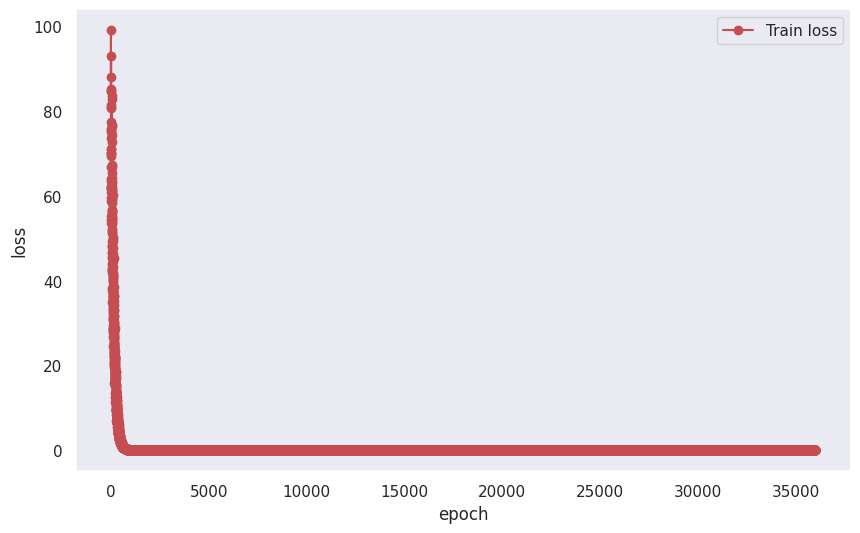

In [12]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()      
            

In [13]:
#confidence interval 
#获取样本和标签之间的置信区间关系 找到上下界  判断样本是否在区间内 在阈值内 即打上标签
# samples = 13542
y_samp = np.zeros((samples,1))
for s in range(samples):
    for b_x,b_y  in student_train_loader:
        y = net (b_x[s]).cpu().detach().numpy()
        y_samp[s] = y.reshape(-1)
# print(y_samp)
lower = np.percentile(y_samp, 2.5, axis = 0)
upper = np.percentile(y_samp, 97.5, axis = 0)
print(f'lower:{lower},upper:{upper}')
#97.5-2.5////99-2


lower:[-0.32501178],upper:[0.39964756]


In [14]:
print(lower,upper)
count = 0 
for i in range(samples):
    for b_x,b_y in student_train_loader:
    #     print(max(b_y),min(b_y)) tensor(5.0000) tensor(0.1500)
    #     print(b_y)
        if lower<=b_y[i].item()<=upper:
            count+=1
per = 1-count/samples
print (count,per,samples-count)
#其实只丢了134条数据
# [-0.54881748] [0.61468787]

[-0.32501178] [0.39964756]
8186 0.004983590616263522 41


In [15]:
# for b_x,b_y in student_train_loader:
#     print(b_y[0].item())
#     b_y[0]=1
#     print(b_y[0])
# lower:[-0.54156185],upper:[0.62291579]
# lower=-0.54156185
# upper=0.62291579
upper=torch.tensor(upper).to(device)
lower= torch.tensor(lower).to(device)
print(lower)
print(upper)




tensor([-0.3250], device='cuda:2', dtype=torch.float64)
tensor([0.3996], device='cuda:2', dtype=torch.float64)


In [16]:
#聚合标签
from http.cookiejar import LoadError
import random
import numpy as np
mu = 0
sigma = 0.05
# sigma =0.1
# sigma = 0.15
# sigma =0.2
# sigma =0.3
# sigma =0.5
# sigma =1
#teahcer labeling
teacher_best_models =[torch.load(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/teacher{tea_num}/best.pth')  for  tea_num in  range(n_teachers)]

pos= torch.ones(samples,n_teachers).to(device)
#用0标记无效值 数据集已ln处理 无ln0
# 记录每个老师 针对拿到的数据 预测出来的如果符合置信区间内，那就记录在内，如果不在 则剔除该值
ccc = 0
sss=0
for tea in range(n_teachers):
    for x,y in student_train_loader:
            teacher_best_models[tea].eval().to(device)
            pred=teacher_best_models[tea].forward(x)
            
            # pred+=random.gauss(mu,sigma)
            for i in range(samples):
                # if lower <= pred[i].item() <= upper :

                if lower.item()<= pred[i].item() <= upper.item():
                    #如果在内 记录
                    pos[i][tea]+=pred[i].item()
                    sss+=1
                else:
                    ccc+=1
print(pos,ccc/(sss+ccc))            

#针对pos中有效值（非0数）进行处理  →  每个老师打出标签做均值求和 
res= torch.zeros(samples,1).to(device)
count_data=0
count_sum=0
 
for i in range(samples):
    for j in range(n_teachers):
        if pos[i][j]!=1:
            count_data+=1
            count_sum+=pos[i][j]
            # 有效
    # if count_data!=0:
    #     cur=count_sum/count_data #data1 +....datan//K
    # else:
    #     cur = count_sum/1
    #     zero+=1#表明n个老师打出的值均无效//避免除以0//零值  但标准化后出现0值 需注意
    if count_data==0:#表明n个老师打出的值均无效//避免除以0//零值
        print('False')
    cur=count_sum/count_data #data1 +....datan//K
    res[i]+=cur#有效的均值标签
    res[i]-=1
print(res)

                 
#     fz1=(fz1+fz)
# # fz1 = fz1/n_teachers
# print(fz1)

# for i in range(samples):
#     for x,y in student_train_loader:
#         fz1[i]= torch.where(fz1[i]>upper,y[i],fz1[i])
#         fz1[i]= torch.where(fz1[i]<lower,y[i],fz1[i])
          
# print(fz1)



tensor([[1.1897, 0.9316, 1.2974,  ..., 1.1745, 0.9431, 1.0438],
        [1.1355, 0.8397, 1.1340,  ..., 1.0000, 1.0000, 0.7667],
        [1.2027, 1.0000, 1.1505,  ..., 0.9418, 1.2588, 0.8202],
        ...,
        [1.1390, 1.0000, 1.2686,  ..., 1.3390, 1.0403, 0.7194],
        [1.0454, 0.7234, 1.3664,  ..., 1.1757, 0.8762, 1.0133],
        [1.1723, 0.7054, 1.2255,  ..., 1.2990, 1.1482, 0.9328]],
       device='cuda:2') 0.08248855394838135
tensor([[0.0411],
        [0.0322],
        [0.0303],
        ...,
        [0.0258],
        [0.0258],
        [0.0258]], device='cuda:2')


In [17]:
#student_label

# torch.as_tensor(torch.from_numpy(student_x[0]), dtype=torch.float)

student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(res,device=device,dtype=torch.float))
student_train_loader1 = DataLoader(student_trainset,batch_size=batch_size)
print('aggregate finished')

# # res.shape

aggregate finished


/tmp/ipykernel_215213/2792088638.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(res,device=device,dtype=torch.float))


In [18]:
#creating student  folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

mkdir_if_missing(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/stu')

In [19]:
# # # neural network model mlp
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.hidden1 = nn.Sequential(nn.Linear(in_features=44, out_features=880, bias=True),
#                                   nn.Dropout(0.7),
#                                   nn.Tanh()
#                                   )
        
#         self.hidden2 = nn.Sequential(nn.Linear(in_features=880, out_features=220, bias=True),
#                                   nn.Dropout(0.7),
#                                   nn.Tanh()
#                                   )
        
#         self.hidden3 = nn.Sequential(nn.Linear(in_features=220, out_features=44, bias=True),
#                                   nn.Dropout(0.5),
#                                   nn.Tanh()
#                                   )
        
#         self.predict = nn.Sequential(nn.Linear(in_features=44, out_features=1, bias=True),
#                                         nn.Tanh())
        
#     def forward(self, x):
#         x = self.hidden1(x)
#         x = self.hidden2(x)
#         x = self.hidden3(x)
#         output = self.predict(x)
#         return output[:, 0]


# mlpreg=MLP().to(device)
# print(mlpreg)
# #initialzing student model
# student_model=mlpreg
# student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-5) 


# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=81, out_features=810, bias=True),
                                  nn.Dropout(0.7),
                                  nn.Tanh()
                                  )
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=810, out_features=162, bias=True),
                                  nn.Dropout(0.7),
                                  nn.Tanh()
                                  )
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=162, out_features=54, bias=True),
                                  nn.Dropout(0.6),
                                  nn.Tanh()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=54, out_features=1, bias=True),
                                        nn.Tanh())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output



mlpreg=MLP().to(device)
print(mlpreg)
#initialzing student model
student_model=mlpreg
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4) 

MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=81, out_features=810, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Tanh()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=810, out_features=162, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Tanh()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=162, out_features=54, bias=True)
    (1): Dropout(p=0.6, inplace=False)
    (2): Tanh()
  )
  (predict): Sequential(
    (0): Linear(in_features=54, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [20]:
#train student model
loss_func=nn.MSELoss()
print('start training')
train_loss_all_stu=[]
minloss=float('inf')
for epoch in  range(1000):
    train_loss = 0
    train_num=0
    student_model.train()
    for b_x,b_y in  student_train_loader1:
        student_optimizer.zero_grad()
        output=student_model(b_x)
        loss=loss_func(output,b_y)
        loss.backward()
        student_optimizer.step()
        # train_loss+=loss.item() * b_x.size(0)
        # train_num += b_x.size(0)
        # loss_stu = train_loss/train_num
        if loss < minloss:
            minloss = loss
            if os.path.exists(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/stu/best2.pth'):
                os.remove(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/stu/best2.pth')
            torch.save(student_model, f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/stu/best2.pth')
    if epoch%1 == 0:
        print(f'student train: Epo:{epoch}  Loss_stu:{loss}')
    train_loss_all_stu.append(loss)
        

start training
student train: Epo:0  Loss_stu:0.011383323930203915
student train: Epo:1  Loss_stu:0.012851214036345482
student train: Epo:2  Loss_stu:0.007528847549110651
student train: Epo:3  Loss_stu:0.007017587777227163
student train: Epo:4  Loss_stu:0.00289433472789824
student train: Epo:5  Loss_stu:0.004872066434472799
student train: Epo:6  Loss_stu:0.0062877340242266655
student train: Epo:7  Loss_stu:0.0031189662404358387
student train: Epo:8  Loss_stu:0.0019492170540615916
student train: Epo:9  Loss_stu:0.0028707075398415327
student train: Epo:10  Loss_stu:0.0030575059354305267
student train: Epo:11  Loss_stu:0.0016751771327108145
student train: Epo:12  Loss_stu:0.002438274910673499
student train: Epo:13  Loss_stu:0.0013168059522286057
student train: Epo:14  Loss_stu:0.0014418085338547826
student train: Epo:15  Loss_stu:0.0017759638139978051
student train: Epo:16  Loss_stu:0.0014437134377658367
student train: Epo:17  Loss_stu:0.0012162983184680343
student train: Epo:18  Loss_stu

In [21]:
# # 保存
# import numpy as np
# d=np.array(train_loss_all_stu)
# d1=np.array(train_loss_all_stu)
# # d2=np.array(train_loss_all_stu)

# # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3).npy',d)   # 保存为.npy格式
# # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3)_1.npy',d1)   # 保存为.npy格式
# # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3)_2.npy',d2)   # 保存为.npy格式



# # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3).npy')
# # d1=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3)_1.npy')
# # d2=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3)_2.npy')

# ###

# # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5).npy',d)   # 保存为.npy格式
# d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5).npy')

# np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5)_1.npy',d1)   # 保存为.npy格式
# d1=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5)_1.npy')

# # d=(d+d1+d2)/3
# d=(d+d1)/2

# d
# d=d.tolist()


In [22]:
            # # 保存
            # import numpy as np
            # d=np.array(train_loss_all_stu)

            # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.05).npy',d)   # 保存为.npy格式
            # # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.1).npy',d)   # 保存为.npy格式
            # # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.15).npy',d)   # 保存为.npy格式
            # # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.2).npy',d)   # 保存为.npy格式
            # # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3).npy',d)   # 保存为.npy格式
            # # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5).npy',d)   # 保存为.npy格式
            # # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,1).npy',d)   # 保存为.npy格式
            # # 读取


            # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.05).npy')
            # # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.1).npy')
            # # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.15).npy')
            # # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.2).npy')
            # # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3).npy')
            # # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5).npy')
            # # d=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,1).npy')
            # d=d.tolist()


In [23]:
                # #读取
                # c=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_average.npy')
                # # c=np.load('/home/ysy/ysy/Fed-ReKD/44_loss.npy')
                # c=c.tolist()
                # #svg
                # import matplotlib.pyplot as plt
                # from matplotlib.pyplot import figure
                # import numpy as np
                # import seaborn as sns
                # from  mpl_toolkits.axisartist import axis_artist

                # sns.set_style("ticks")
                # figure(num=None, figsize=(6, 4), dpi=600)
                # # figsize的2.8和1.7指的是英寸，dpi指定图片分辨率。那么图片就是（2.8*300）*（1.7*300）像素大小
                # plt.plot(c, 'royalblue', label='Without LDP')

                # plt.plot(d, 'darkorange', label='With (0,0.05)gauss')
                # # plt.plot(d, 'darkorange', label='With (0,0.1)gauss')
                # # plt.plot(d, 'darkorange', label='With (0,0.15)gauss')
                # # plt.plot(d, 'darkorange', label='With (0,0.2)gauss')
                # # plt.plot(d, 'darkorange', label='With (0,0.3)gauss')
                # # plt.plot(d, 'darkorange', label='With (0,0.5)gauss')
                # # plt.plot(d, 'darkorange', label='With (0,1)gauss')
                # # 画图，并指定颜色

                # plt.xticks(fontproperties = 'Times New Roman', fontsize=8)
                # plt.yticks(np.arange(0, 0.031, 0.005), fontproperties = 'Times New Roman', fontsize=8)
                # # 指定横纵坐标的字体以及字体大小，记住是fontsize不是size。yticks上我还用numpy指定了坐标轴的变化范围。

                # plt.legend(loc='upper right', prop={'family':'Times New Roman', 'size':12})
                # # 图上的legend，记住字体是要用prop以字典形式设置的，而且字的大小是size不是fontsize，这个容易和xticks的命令弄混

                # plt.title('Zillow Train Performance', fontdict={'family' : 'Times New Roman', 'size':12})
                # # 指定图上标题的字体及大小

                # plt.xlabel('Epochs', fontdict={'family' : 'Times New Roman', 'size':12})
                # plt.ylabel('Loss', fontdict={'family' : 'Times New Roman', 'size':12})
                # # 指定横纵坐标描述的字体及大小
                # plt.xlim(-1,100)
                # plt.ylim(0.00,0.03)

                # plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.05).pdf', dpi=600, bbox_inches="tight")
                # # plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.1).pdf', dpi=600, bbox_inches="tight")
                # # plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.15).pdf', dpi=600, bbox_inches="tight")
                # # plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.2).pdf', dpi=600, bbox_inches="tight")
                # # plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.3).pdf', dpi=600, bbox_inches="tight")
                # # plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.5).pdf', dpi=600, bbox_inches="tight")
                # # plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,1).pdf', dpi=600, bbox_inches="tight")


                # # 保存文件，dpi指定保存文件的分辨率
                # # bbox_inches="tight" 可以保存图上所有的信息，不会出现横纵坐标轴的描述存掉了的情况


                # plt.show()
                # # 记住，如果你要show()的话，一定要先savefig，再show。如果你先show了，存出来的就是一张白纸。


In [24]:
#eval  student model
# teacher_best_models =[torch.load(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/teacher{tea_num}/best.pth')  for  tea_num in  range(n_teachers)]
student_best_model =torch.load('/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/stu/best2.pth')

for s_x,s_y in  student_test_loader:
    student_best_model.eval().to(device)
    pred=student_best_model(s_x)
    loss_test=loss_func(pred,s_y) 
print(f'student test Loss:{loss_test}',f'\n predict:{pred}',f'\n b_y:{s_y}')

# loss_all=0
# for i in range(samples):
#     for s_x,s_y in student_test_loader:
#         student_best_model.eval().to(device)
#         pred[i]=student_best_model(s_x[i])
#         loss_test=loss_func(pred[i],s_y[i])
#         loss_all+=loss_test
#         print(f'stu loss',f'\n now menber{i} loss:{loss_test}')
#     # print(b_x,b_y)
# ip = loss_all/samples
# print(f'average:{ip}')
# array = y.cpu().numpy()
# print(len(s_x))
#找到置信区间 若在student_test_loader中的x的置信度符合该置信区间的 我就加入到新的测试集中，并加入对应标签。训练取loss
# 给各个地方打上标签，对不熟的标签 进行剔除投票    关于隐私保护机制/// 拉普拉斯 针对数值型数据 加入独立同分布的高斯噪声  根据噪声与隐私预算 做调整 //指数机制  针对非数值型数据  设置质量函数 选择输出
# 0.025 //0.16//0.037 //0.258

student test Loss:0.00695079006254673 
 predict:tensor([[0.0258],
        [0.0259],
        [0.0259],
        ...,
        [0.0258],
        [0.0259],
        [0.0259]], device='cuda:2', grad_fn=<TanhBackward0>) 
 b_y:tensor([ 0.0328,  0.1337, -0.0440,  ...,  0.0711, -0.0356,  0.0421],
       device='cuda:2')


/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([8227])) that is different to the input size (torch.Size([8227, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
